In [1]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

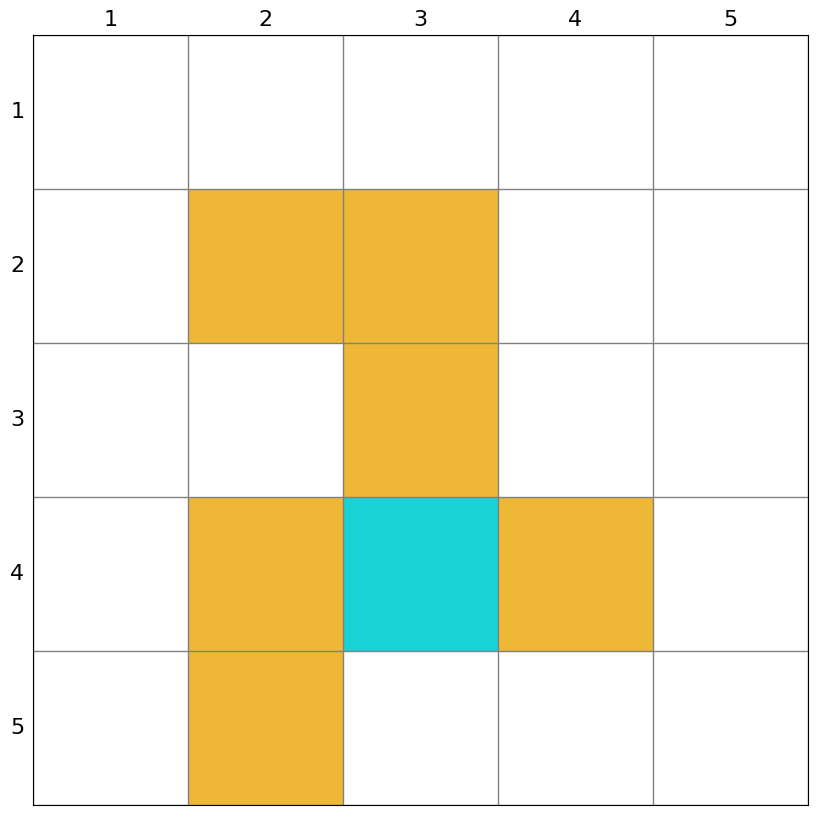

In [2]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')

In [3]:
class QNET(nn.Module):
    def __init__(self, input_dim=3, output_dim=1):
        super(QNET, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_dim),
        )

    def forward(self, x):
        x = x.type(torch.float32)
        return self.fc(x)

q_net = QNET()
q_net_delay = QNET()
#复制参数
q_net_delay.load_state_dict(q_net.state_dict())

<All keys matched successfully>

In [4]:
def get_data_iter(env, episode, batch_size=64, is_train=True):
    """构造一个PyTorch数据迭代器"""
    reward = []
    state_action = []
    next_state = []
    for i in range(len(episode)):
        reward.append(episode[i]['reward'])
        action = episode[i]['action']
        y, x = env.state2pos(episode[i]['state'])
        state_action.append((y, x, action))
        y, x = env.state2pos(episode[i]['next_state'])
        next_state.append((y, x))
    reward = torch.tensor(reward).reshape(-1, 1)
    state_action = torch.tensor(state_action)
    next_state = torch.tensor(next_state)
    data_arrays = (state_action, reward, next_state)
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train, drop_last=False)

In [5]:
def obtain_episode(env, policy, start_state, start_action, length):
    env.agent_location = env.state2pos(start_state)
    episode = []
    next_action = start_action
    next_state = start_state
    while length > 0:
        length -= 1
        state = next_state
        action = next_action
        _, reward, done, _, _ = env.step(action)
        next_state = env.pos2state(env.agent_location)
        next_action = np.random.choice(np.arange(len(policy[next_state])),
                                           p=policy[next_state])
        episode.append({"state": state, "action": action, "reward": reward, "next_state": next_state,
                            "next_action": next_action})
    return episode

In [6]:
def dqn(env , lr = 0.01 , gamma = 0.99 , episode_length = 5000 , epochs = 600 ,batch_size = 100 , updata_step = 5):
    q_net = QNET()
    q_target_net = QNET()
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size
    state_value = np.zeros(shape=state_space_size)
    q_target_net.load_state_dict(q_net.state_dict())  # 同步目标网络和当前网络
    optm = torch.optim.SGD(q_net.parameters(), lr)
    policy = np.ones((state_space_size, action_space_size)) / action_space_size
    episode = obtain_episode(env, policy, 0, 0 ,1001)
    data_iter = get_data_iter(env, episode, batch_size)
    loss_fn = torch.nn.MSELoss()
    approximation_q_value = np.zeros(shape=(state_space_size, action_space_size))
    i = 0
    
    for _ in range(epochs):
        for state_action, reward, next_state in data_iter:
            i += 1
            q_value = q_net(state_action)  # 获取当前 Q 网络的输出
            q_value_target = torch.empty((batch_size, 0))  # 初始化 q_value_target

            for action in range(action_space_size):
                s_a = torch.cat((next_state, torch.full((batch_size, 1), action)), dim=1)#torch.full((batch_size, 1), action) 是 PyTorch 中用于创建一个形状为 (batch_size, 1) 的张量，其中每个元素都被填充为指定的 action 值。
                q_value_target = torch.cat((q_value_target, q_target_net(s_a).detach()), dim=1)  # 获取目标网络输出，并 detach
                
            q_star = torch.max(q_value_target, dim=1, keepdim=True)[0]  # 获取下个状态的最大 q 值
            y_target_value = reward + gamma * q_star  # 计算 y 值
            l = loss_fn(q_value, y_target_value)  # 损失计算
            
            optm.zero_grad()  # 梯度清零
            l.backward()  # 反向传播
            optm.step()  # 更新参数
            
            if i % updata_step == 0 and i != 0:
                q_target_net.load_state_dict(q_net.state_dict())  # 定期更新目标网络

        # 更新策略
        for s in range(state_space_size):
            y, x = env.state2pos(s)
            for a in range(action_space_size):
                approximation_q_value[s, a] = float(q_net(torch.tensor((y, x, a)).reshape(-1, 3)))
            q_star_index = approximation_q_value[s].argmax()  # 找到最优动作
            policy[s] = np.zeros(action_space_size)  # 重置策略
            policy[s, q_star_index] = 1  # 选择最优动作
            state_value[s] = approximation_q_value[s, q_star_index]  # 更新状态值
        
    return policy

In [7]:
policy = dqn(env)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 100 for tensor number 1 in the list.

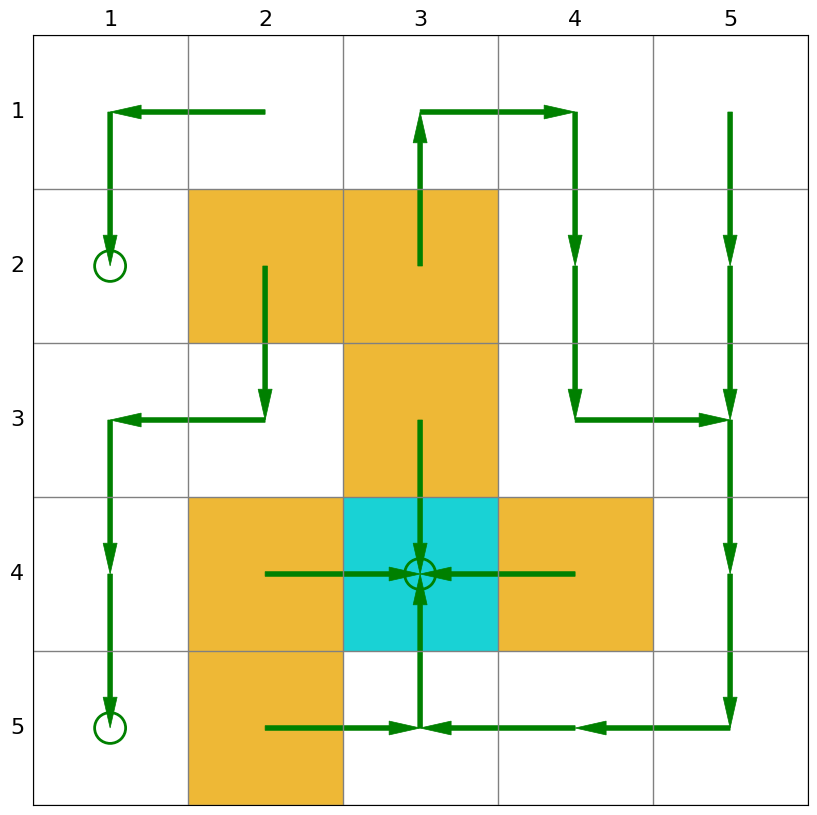

In [59]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()